In [1]:
%matplotlib inline
# %matplotlib widget

# Analysis of subjects

In [2]:
import csv
import os
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.facecolor':'white'})

In [3]:
from demapper.code.utils.analyze import extract_dataset, get_all_parameters, plot_results, plot_limits
from demapper.code.utils.config_w3c import DATASETS, FILTERS, get_plot_columns, extract_params_f

circle_loss_threshold = 10.0

### Run for one dataset

In [5]:
PICKED_DATASET = 'ss_w3cv5'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)


all_sbjs, sbjs_map = get_all_parameters(df, PICKED_DATASET)

print(max_values)
df.sample(5)

len(stats):  10080
len(results):  10080
Total 14 subjects:
SBJ20
SBJ20-50.0
SBJ20-75.0
SBJ20-83.0
SBJ21
SBJ40
SBJ40-50.0
SBJ40-75.0
SBJ40-83.0
SBJ41
SBJ99
SBJ99-50.0
SBJ99-75.0
SBJ99-83.0
Extra combinations:
SBJ2x : ['SBJ20', 'SBJ21']
SBJ4x : ['SBJ40', 'SBJ41', 'SBJ42', 'SBJ43']
SBJxx-50 : ['SBJ20-50.0', 'SBJ40-50.0', 'SBJ99-50.0']
SBJxx-75 : ['SBJ20-75.0', 'SBJ40-75.0', 'SBJ99-75.0']
SBJxx-83 : ['SBJ20-83.0', 'SBJ40-83.0', 'SBJ99-83.0']
SBJxx-99 : ['SBJ20', 'SBJ40', 'SBJ99']
{'CircleLoss': 53.699999999999996, 'TransitionBetweeness': 28.5}


,Mapper,SBJ,preptype,dist,K,R,G,linkbins,CircleLoss,TransitionBetweeness,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
4881,CustomBDLMapper_PCA_euclidean_48_20_55_10,SBJ41,PCA,euclidean,48,20,55,10,53.700000,28.5,0.735043,0.615477,0.521368,23.0,4.01875,0.212788,75.5009,5.61877
8778,CustomBDLMapper_none_cosine_32_30_70_20,SBJ20,none,cosine,32,30,70,20,5.406250,28.5,0.881757,0.985603,0.472973,15.0,3.34852,0.186494,317.0320,4.90179
997,CustomBDLMapper_PCA_chebychev_48_30_85_20,SBJ20-83.0,PCA,chebychev,48,30,85,20,3.638314,28.5,1.000000,1.000000,0.585526,12.0,3.12809,0.237880,1330.4100,6.58716
6943,CustomBDLMapper_none_cityblock_48_20_70_20,SBJ99-83.0,none,cityblock,48,20,70,20,53.700000,28.5,0.769874,0.556761,0.343096,19.0,3.59203,0.366276,122.4460,5.85922
8925,CustomBDLMapper_none_cosine_48_20_55_20,SBJ40-75.0,none,cosine,48,20,55,20,5.000000,28.5,0.776471,0.987200,0.435294,10.0,3.01463,0.324605,39.7880,3.35686


In [137]:

target_metrics = ['CircleLossRev', 'TransitionBetweenessRev', 'coverage_nodes', 'hrfdur_stat', 'distances_entropy']
log_metrics = ['CircleLossRev', 'TransitionBetweenessRev']

df['CircleLossRev'] = df.apply(lambda x: 1.0 / x['CircleLoss'] if x['CircleLoss'] > 0 else 100, axis=1)
df['TransitionBetweenessRev'] = df.apply(lambda x: 1.0 / (x['TransitionBetweeness'] + 1), axis=1)


plot_results(df, 'SBJ99_KRG', ['SBJ99'], 'K', 'R', 'G', target_metrics, log_metrics, resdir=resdir)

# for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
#     plot_results(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics, log_metrics, resdir=resdir)
    

In [23]:
# Plot limits

target_metrics = {
    'CircleLoss': [0, circle_loss_threshold],
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99],
    'coverage_nodes': [0.7, 1.0],
#     'hrfdur_stat': [0.15, 1.0],
    'distances_entropy': [2.0, 10000.0]
}

fixedV, indexV, colV = get_plot_columns(filter_by)

for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
    plot_limits(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics, resdir=resdir)
    


100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:01<00:00,  9.10s/it]


## Recompute for all analysis that we have

In [8]:

target_metrics = ['CircleLossRev', 'TransitionBetweenessRev', 'coverage_nodes', 'hrfdur_stat', 'distances_entropy']
log_metrics = ['CircleLossRev', 'TransitionBetweenessRev']

circle_loss_threshold = 2.0

target_metrics_limits = {
#     'CircleLoss': [0, circle_loss_threshold],
#     'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0]
}

#     'hrfdur_stat': [0.15, 1.0], # SKip using hrfdurstat since it doesn't have an impact at >= 15%

# hightr_w3cv2  ss_w3cv5

for dataset_name in DATASETS.keys():
#     if dataset_name not in ['wnoise_w3cv4', 'wnoise_w3cv5', 'wnoise_w3cv6']:
    if dataset_name not in ['hightr_w3cv4euc']:
        continue
    print('======= Processing', dataset_name)
    datadir = DATASETS[dataset_name]
    stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
    results_path = os.path.join(datadir, 'scores-all.csv')

    try:
        for filter_by in FILTERS[dataset_name]:
            resdir = datadir
            if len(FILTERS[dataset_name]) > 1:
                resdir = os.path.join(datadir, filter_by)
                os.makedirs(resdir, exist_ok=True)
            df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
            all_sbjs, sbjs_map = get_all_parameters(df, dataset_name, silent=True)

            fixedV, indexV, colV = get_plot_columns(filter_by)

            df['CircleLossRev'] = df.apply(lambda x: 1.0 / x['CircleLoss'] if x['CircleLoss'] > 0 else 100, axis=1)
            df['TransitionBetweenessRev'] = df.apply(lambda x: 1.0 / (x['TransitionBetweeness'] + 1), axis=1)    
#             for sbj_group_name, sbj_group in tqdm(sbjs_map.items(), desc='plot_results'):
#                 plot_results(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics, log_metrics, resdir=resdir)

            target_metrics_limits['TransitionBetweeness'] = [0.0, max_values['TransitionBetweeness'] * 0.99]
            for sbj_group_name, sbj_group in tqdm(sbjs_map.items(), desc='plot_limits'):
                plot_limits(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics_limits, resdir=resdir)
    except Exception as err:
        print("Warning! Didn't process '{}' because:".format(dataset_name))
        print(err)
        raise err

======= Processing hightr_w3cv4euc
len(stats):  4200
len(results):  4200


plot_limits: 100%|██████████████████████████████████████████████████████████████████████| 9/9 [01:16<00:00,  8.54s/it]


### Create links to download and then create a grid

In [7]:

REMOTE_DATASET_PATHS = {
    'ss_w3cv1': '/scratch/groups/saggar/demapper-w3c/mappers_w3cv1.json',
    'ss_w3cv2': '/scratch/groups/saggar/demapper-w3c/mappers_w3cv2.json',
    'ss_w3cv3': '/scratch/groups/saggar/demapper-w3c/mappers_w3cv3.json',
    'ss_w3cv4': '/scratch/groups/saggar/demapper-w3c/mappers_w3cv4.json',
    'ss_w3cv5': '/scratch/groups/saggar/demapper-w3c/mappers_w3cv5dist.json',
    'ss_w3cv6': '/scratch/groups/saggar/demapper-w3c/mappers_w3cv6dist.json'
}

dataset_id = 'ss_w3cv3'
local_dataset_path = DATASETS[dataset_id]
os.makedirs(os.path.join(local_dataset_path, 'mappers_plots'), exist_ok = True)
os.makedirs(os.path.join(local_dataset_path, 'mappers_combined'), exist_ok = True)
remote_dataset_path = REMOTE_DATASET_PATHS[dataset_id]
remote_analysis_path = REMOTE_DATASET_PATHS[dataset_id].replace('mappers_w3c', 'analysis/mappers_w3c')



In [8]:
mappers = []
k = 20
for r in range(10, 50, 10):
    for g in range(50, 100, 10):
        mappers.append({
            'mapper': 'BDLMapper_{k}_{r}_{g}'.format(k=k, r=r, g=g),
            'R': r,
            'G': g,
        })
        

sbjs = ['SBJ99', 'SBJ99-83.0', 'SBJ99-75.0', 'SBJ99-50.0']

files = ['plot_task-G.png']


In [9]:
print("###### Copy the files to mappers_plots")

print('mkdir {}/mappers_plots'.format(remote_analysis_path))

table = []
for s in sbjs:
    for m in mappers:
        for f in files:
            item = m.copy()
            item['sbj'] = s
            item['file'] = f
            table.append(item)
            print('cp {ds_path}/{s}/{m}/{f} {an_path}/mappers_plots/{s}_{m}_{f}'.format(
                ds_path=remote_dataset_path,
                an_path=remote_analysis_path,
                s=s, m=m['mapper'], f=f))
            
print("###### Copy the files locally")
print('scp -r "hasegan@login.sherlock.stanford.edu:{}/mappers_plots/*" {}'.format(
    remote_analysis_path,
    os.path.join(local_dataset_path, 'mappers_plots/')))

###### Copy the files to mappers_plots
mkdir /scratch/groups/saggar/demapper-w3c/analysis/mappers_w3cv3.json/mappers_plots
cp /scratch/groups/saggar/demapper-w3c/mappers_w3cv3.json/SBJ99/BDLMapper_20_10_50/plot_task-G.png /scratch/groups/saggar/demapper-w3c/analysis/mappers_w3cv3.json/mappers_plots/SBJ99_BDLMapper_20_10_50_plot_task-G.png
cp /scratch/groups/saggar/demapper-w3c/mappers_w3cv3.json/SBJ99/BDLMapper_20_10_60/plot_task-G.png /scratch/groups/saggar/demapper-w3c/analysis/mappers_w3cv3.json/mappers_plots/SBJ99_BDLMapper_20_10_60_plot_task-G.png
cp /scratch/groups/saggar/demapper-w3c/mappers_w3cv3.json/SBJ99/BDLMapper_20_10_70/plot_task-G.png /scratch/groups/saggar/demapper-w3c/analysis/mappers_w3cv3.json/mappers_plots/SBJ99_BDLMapper_20_10_70_plot_task-G.png
cp /scratch/groups/saggar/demapper-w3c/mappers_w3cv3.json/SBJ99/BDLMapper_20_10_80/plot_task-G.png /scratch/groups/saggar/demapper-w3c/analysis/mappers_w3cv3.json/mappers_plots/SBJ99_BDLMapper_20_10_80_plot_task-G.png
cp /s

In [19]:
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

sns.set(style = "whitegrid")

def create_axis(df, axis_hps, idx=0):
    if idx == len(axis_hps):
        return [{}]
    hp_name = axis_hps[idx]
    hp_vals = df[hp_name].drop_duplicates().to_numpy()
    vals = []
    hp_vals = sorted(sorted(hp_vals), key=lambda x: x != 'none')
    for hpv in hp_vals:
        df_hp = df[df[hp_name] == hpv]
        val = create_axis(df_hp, axis_hps, idx+1)
        if len(hp_vals) > 1:
            for v in val:
                v[hp_name] = hpv
        vals.extend(val)
    return vals


def get_item_path(basedir, item):
    return os.path.join(
        basedir, 'mappers_plots', '{s}_{m}_{f}'.format(
            s=item['sbj'].tolist()[0],
            m=item['mapper'].tolist()[0],
            f=item['file'].tolist()[0]))


def get_item_path_v2(basedir, item, label=''):
    return os.path.join(
        basedir, item['sbj'].tolist()[0], item['mapper'].tolist()[0], 'plot_task{}.png'.format(label))


def plot_image(img_path, ax):
    im = Image.open(img_path)
    img = np.array(im)
    ax.imshow(img)
    del img
    del im
    return ax

def plot_grid(df, sbj, hps_x, hps_y, hps_fixed_vals, analysis_path, regen=False, text_f=None, show_plot=False, plot_label=''):
    ax_x = create_axis(df, hps_x)
    ax_y = create_axis(df, hps_y)
    ax_y.reverse()
    
    x_keys = sorted(list(set([k for x in ax_x for k,v in x.items()])))
    y_keys = sorted(list(set([k for y in ax_y for k,v in y.items()])))
    fixed_toks = sorted(['{}_{}'.format(k,v) for k,v in hps_fixed_vals.items()])
    savefig_path = os.path.join(
        analysis_path, # 'mappers_combined',
        'comb{}_{}.png'.format(
            sbj,
            '_'.join(['x'] + x_keys + ['y'] + y_keys + fixed_toks)))
    
    if os.path.isfile(savefig_path) and not regen:
        return

    ncols = len(ax_x)
    nrows = len(ax_y)
    fsize = 20
    fig, axr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fsize * (ncols/nrows)*1.1,fsize))

    for r,(y,axc) in enumerate(zip(ax_y,axr)):
        for c,(x,ax) in enumerate(zip(ax_x,axc)):
            K = {'sbj':sbj, **x, **y, **hps_fixed_vals}
            df_filtered = df
            for k,v in K.items():
                df_filtered = df_filtered[df_filtered[k] == v]
            if len(df_filtered) == 0:
                ax.axis('off')
                continue
            assert len(df_filtered) == 1, 'Too many ({}) items found for {}, {}, {}'.format(
                len(df_filtered), x, y, hps_fixed_vals)
            item = df_filtered
            sbj = item['sbj'].to_numpy()[0]

            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            if r == len(ax_y)-1:
                ax.set_xlabel(' '.join([str(x[k]) for k in hps_x if k in x]))
                ax.xaxis.set_label_position("bottom")
            if c == 0:
                ax.set_ylabel(' '.join([str(y[k]) for k in hps_y if k in y]))

            img_path = get_item_path_v2(analysis_path, item, plot_label)
            if not os.path.isfile(img_path):
    #             ax.axis('off')
                print('Skipping as plot not found at {}'.format(img_path))
                continue
        
#             modd = df_filtered[['preembed_mod_full', 'preembed_mod_wout_ac', 'embed_modd_bin', 'embed_modd_wout_ac']].to_numpy()[0]
#             modd = [str(round(m,3)) for m in modd]
#             title = ' -> '.join([', '.join(modd[0:2]), ', '.join(modd[2:4])])
#             ax.set_title(title)
            if text_f:
                ax = text_f(ax, item)
            ax = plot_image(img_path, ax)
    plt.tight_layout()
    
    plt.savefig(savefig_path, dpi=150)
    if show_plot:
        plt.show()
    plt.close()
    
# plot_grid(df, 'SBJ01', hps_x, hps_y, {'knnparam_gains': 1.0})


In [15]:
df = pd.DataFrame(data=table)

for sbj in tqdm(sbjs):
    plot_grid(df, sbj, ['R'], ['G'], {}, local_dataset_path, regen=True)


  0%|                                                                                           | 0/4 [00:00<?, ?it/s]

Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99/BDLMapper_20_10_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99/BDLMapper_20_20_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99/BDLMapper_20_30_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99/BDLMapper_20_40_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99/BDLMapper_20_10_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99/BDLMapper_20_20_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3

 25%|████████████████████▊                                                              | 1/4 [00:00<00:02,  1.04it/s]

Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-83.0/BDLMapper_20_10_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-83.0/BDLMapper_20_20_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-83.0/BDLMapper_20_30_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-83.0/BDLMapper_20_40_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-83.0/BDLMapper_20_10_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-83.0/BDLMapper_20_20_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results

 50%|█████████████████████████████████████████▌                                         | 2/4 [00:01<00:01,  1.22it/s]

Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-75.0/BDLMapper_20_10_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-75.0/BDLMapper_20_20_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-75.0/BDLMapper_20_30_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-75.0/BDLMapper_20_40_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-75.0/BDLMapper_20_10_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-75.0/BDLMapper_20_20_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results

 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [00:02<00:00,  1.26it/s]

Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-50.0/BDLMapper_20_10_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-50.0/BDLMapper_20_20_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-50.0/BDLMapper_20_30_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-50.0/BDLMapper_20_40_50/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-50.0/BDLMapper_20_10_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/SBJ99-50.0/BDLMapper_20_20_60/plot_task_alt1.png
Skipping as plot not found at /Users/dh/workspace/BDL/demapper/results

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


In [11]:
local_dataset_path

'/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/'

In [28]:
df = pd.DataFrame(data=table)

# for sbj in tqdm(sbjs):
    
sbj = 'SBJ99'
plot_grid(df, sbj, ['G'], ['R'], {}, '/Users/dh/workspace/BDL/demapper/results/w3c_ss', regen=True)


In [26]:
ax_y = create_axis(df, ['R'])

ax_y.reverse()
ax_y

[{'R': 40}, {'R': 30}, {'R': 20}, {'R': 10}]

### Plot the group counts as bars

In [28]:
def filter_dataframe(df, filters):
    df_filter = None
    for fi, (key, vals) in enumerate(filters.items()):
        df_f = df[key] == vals[0]
        for i in range(1, len(vals)):
            df_f = (df_f | (df[key] == vals[i]))
        if fi == 0:
            df_filter = df_f
        else:
            df_filter = (df_f & df_filter)
        
    df_filtered = df[df_filter]
    return df_filtered

def count_passing(df, limits):
    df_filter = None
    for fi, (target, lims) in enumerate(limits.items()):
        df_f = (df[target] >= lims[0]) & (df[target] <= lims[1]) 
        if fi == 0:
            df_filter = df_f
        else:
            df_filter = (df_f & df_filter)
    return(sum(df_filter))


In [10]:
PICKED_DATASET = 'ss_w3cv5lens_fast'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')


In [11]:
filters = {
    'SBJ': ['SBJ99'],
#     'preptype': ['none'],
#     'linkbins': [10]
}

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}
df_geodists = filter_dataframe(df, filters)
print('After filter: ', len(df_geodists))

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}
df_nongeodists = filter_dataframe(df, filters)
print('After filter: ', len(df_nongeodists))

len(stats):  7000
len(results):  7000
After filter:  375
len(stats):  7000
len(results):  7000
After filter:  125


In [92]:
dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']
Kvals = df_geodists['K'].drop_duplicates().to_numpy()

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits_nongeo)
    table.append({
        'dist': dist,
        'K': 'non geodesic',
        'count': cnt,
        'perc': cnt / len(fdf),
        
    })
    for k in Kvals:
        fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits_geo)
        table.append({
            'dist': dist,
            'K': 'geodesic k={}'.format(k),
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0
        })
        
counts_df = pd.DataFrame(data=table)

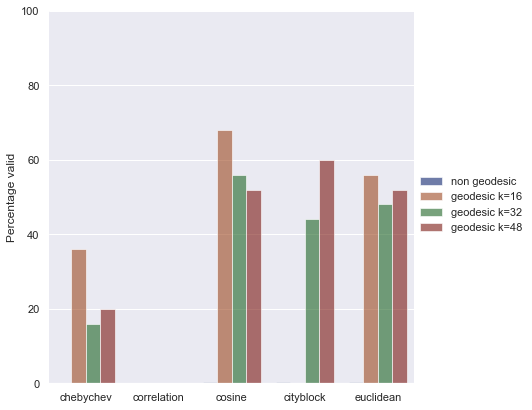

In [94]:
g = sns.catplot(
    data=counts_df, kind="bar",
    x="dist", y="perc", hue="K",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Percentage valid")
g.set(ylim=(0, 100))
g.legend.set_title("")
plt.show()

#### Generate for all

In [11]:

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASETs = ['ss_w3cv5lens2_fast', 'wnoise_w3cv5lens2_fast', 'hightr_w3cv5lens2_fast']

for PICKED_DATASET in PICKED_DATASETs:
    datadir = DATASETS[PICKED_DATASET]
    stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
    results_path = os.path.join(datadir, 'scores-all.csv')


    # Extract geodesic distances mappers
    filter_by = FILTERS[PICKED_DATASET][0]
    df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
    target_metrics_limits_geo = {
        'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
        'coverage_nodes': [0.7, 1.0],
        'distances_entropy': [2.0, 10000.0],
        'hrfdur_stat': [0.15, 1.0],
    }

    # Extract non-geodesic distances mappers
    filter_by = FILTERS[PICKED_DATASET][1]
    df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
    target_metrics_limits_nongeo = {
        'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
        'coverage_nodes': [0.7, 1.0],
        'distances_entropy': [2.0, 10000.0],
        'hrfdur_stat': [0.15, 1.0],
    }

    sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
    for sbj in tqdm(sbjs):
        sbj_filters = {
            'SBJ': [sbj],
        }

        df_geodists = filter_dataframe(df_geo, sbj_filters)
        df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
        Kvals = df_geodists['K'].drop_duplicates().to_numpy()

        table = []
        # counts = {d:{} for d in dists}
        for dist in dists:

            fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
            cnt = count_passing(fdf, target_metrics_limits_nongeo)
            table.append({
                'dist': dist,
                'K': 'non geodesic',
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,

            })
            for k in sorted(Kvals):
                fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
                cnt = count_passing(fdf, target_metrics_limits_geo)
                table.append({
                    'dist': dist,
                    'K': 'geodesic k={}'.format(k),
                    'count': cnt,
                    'perc': cnt / len(fdf) * 100.0
                })

        counts_df = pd.DataFrame(data=table)

        g = sns.catplot(
            data=counts_df, kind="bar",
            x="dist", y="perc", hue="K",
            ci="sd", palette="dark", alpha=.6, height=6
        )
        g.despine(left=True)
        g.set_axis_labels("", "Percentage valid")
        g.set(ylim=(0, 100))
        g.legend.set_title("")
#         plt.tight_layout()

        save_path = os.path.join(datadir, 'dists_{}_distrib.png'.format(sbj))
        plt.savefig(save_path, dpi=150)
        plt.close()
        # plt.show()


len(stats):  6000
len(results):  6000
len(stats):  6000
len(results):  6000


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.57it/s]


len(stats):  4500
len(results):  4500
len(stats):  4500
len(results):  4500


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


len(stats):  4500
len(results):  4500
len(stats):  4500
len(results):  4500


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.50it/s]


In [10]:
sorted(Kvals)

[4, 6, 24, 32, 96]

In [12]:

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASETs = ['ss_w3cv6lens2_fast', 'wnoise_w3cv6lens2_fast', 'hightr_w3cv6lens2_fast']

for PICKED_DATASET in PICKED_DATASETs:
    datadir = DATASETS[PICKED_DATASET]
    stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
    results_path = os.path.join(datadir, 'scores-all.csv')

    # Extract geodesic distances mappers
    filter_by = FILTERS[PICKED_DATASET][0]
    df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
    target_metrics_limits_geo = {
        'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
        'coverage_nodes': [0.7, 1.0],
        'distances_entropy': [2.0, 10000.0],
        'hrfdur_stat': [0.15, 1.0],
    }

    sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
    for sbj in tqdm(sbjs):
        sbj_filters = {
            'SBJ': [sbj],
        }

        df_geodists = filter_dataframe(df_geo, sbj_filters)
        Kvals = df_geodists['K'].drop_duplicates().to_numpy()

        table = []
        # counts = {d:{} for d in dists}
        for dist in dists:
            for k in sorted(Kvals):
                fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
                cnt = count_passing(fdf, target_metrics_limits_geo)
                table.append({
                    'dist': dist,
                    'K': 'geodesic k={}'.format(k),
                    'count': cnt,
                    'perc': cnt / len(fdf) * 100.0
                })

        counts_df = pd.DataFrame(data=table)

        g = sns.catplot(
            data=counts_df, kind="bar",
            x="dist", y="perc", hue="K",
            ci="sd", palette=sns.color_palette("dark")[1:], alpha=.6, height=6
        )
        g.despine(left=True)
        g.set_axis_labels("", "Percentage valid")
        g.set(ylim=(0, 100))
        g.legend.set_title("")
#         plt.tight_layout()

        save_path = os.path.join(datadir, 'dists_{}_distrib.png'.format(sbj))
        plt.savefig(save_path, dpi=150)
        plt.close()
        # plt.show()


len(stats):  5000
len(results):  5000


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


len(stats):  3750
len(results):  3750


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.44it/s]


len(stats):  3750
len(results):  3750


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.04it/s]


[(0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

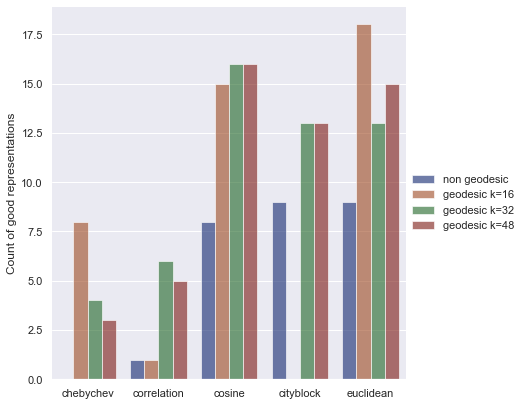

In [9]:
g = sns.catplot(
    data=counts_df, kind="bar",
    x="dist", y="count", hue="K",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Count of good representations")
g.legend.set_title("")

### K values (k-values)

In [27]:
def add_col_passing(df, limits):
    df_filter = None
    for fi, (target, lims) in enumerate(limits.items()):
        df_f = (df[target] >= lims[0]) & (df[target] <= lims[1]) 
        if fi == 0:
            df_filter = df_f
        else:
            df_filter = (df_f & df_filter)
    df2 = df.copy(deep=True)
    df2['passing'] = df_filter
    return df2


In [84]:

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'ss_w3cv5kval_fast'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
# for sbj in tqdm(sbjs):
    
sbj = 'SBJ99'
sbj_filters = {
    'SBJ': [sbj],
}

df_geodists = filter_dataframe(df_geo, sbj_filters)
Kvals = df_geodists['K'].drop_duplicates().to_numpy()

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    for k in Kvals:
        fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits_geo)
        table.append({
            'Distance type': dist,
            'K': k,
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0
        })

counts_df = pd.DataFrame(data=table)

f, ax = plt.subplots(figsize=(10, 5))
# ax.set(xscale="log")

g = sns.lineplot(data=counts_df, x="K", y="perc", hue="Distance type", style="Distance type", markers=True, dashes=False)
g.set(xscale="log")
g.set_ylabel("Percentage valid")
g.set_xticks(sorted(Kvals))
g.set_xticklabels(sorted(Kvals))
g.set(ylim=(0, 100))
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'kvalue_dists_{}_distrib.png'.format(sbj))
plt.savefig(save_path, dpi=150)
plt.close()


len(stats):  2250
len(results):  2250


In [86]:
# Generate the 5x5 orange plots 

for dist in dists:
    fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [12] })
    fdf = add_col_passing(fdf, target_metrics_limits_geo)
    fdf = fdf.pivot(index='R', columns='G', values='passing').sort_values('R', ascending=False)
    fdf = fdf * 0.75

    plt.figure(figsize=(2.5,2.5))
    ax = sns.heatmap(fdf, cbar=False, vmax=1.0)
    if dist == 'euclidean':
        ax.set_xlabel('Gain')
        ax.set_ylabel('Resolution')
    else:
        ax.set(xlabel=None, ylabel=None)
        ax.tick_params(bottom=False, left=False,
                labelleft=False, labelbottom=False)

    save_path = os.path.join(datadir, '{}_k{}_{}_box.png'.format(dist, 12, sbj))
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [87]:

### Non-geodesic distribution
dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'ss_w3cv5lens2_fast'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
# for sbj in tqdm(sbjs):
    
sbj = 'SBJ99'
sbj_filters = {
    'SBJ': [sbj],
}

df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)

table = []
table = []
for dist in dists:
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits_nongeo)
    table.append({
        'dist': dist,
        'K': 'non geodesic',
        'count': cnt,
        'perc': cnt / len(fdf) * 100.0,

    })


counts_df = pd.DataFrame(data=table)

g = sns.catplot(
    data=counts_df, kind="bar",
    x="dist", y="perc",
    ci="sd", palette="dark", alpha=.7, height=6, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("", "Percentage valid")
g.set(ylim=(0, 100))
g.set_xticklabels(rotation=70)
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'nongeo_dists_{}_distrib.png'.format(sbj))
plt.savefig(save_path, dpi=150)
plt.close()


len(stats):  6000
len(results):  6000


In [88]:
# Generate the 5x5 orange plots 

for dist in dists:
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    fdf = add_col_passing(fdf, target_metrics_limits_nongeo)
    fdf = fdf.pivot(index='R', columns='G', values='passing').sort_values('R', ascending=False)
    fdf = fdf * 0.75

    plt.figure(figsize=(2.5,2.5))
    ax = sns.heatmap(fdf, cbar=False, vmax=1.0)
#     if dist == 'euclidean':
#         ax.set_xlabel('Gain')
#         ax.set_ylabel('Resolution')
#     else:
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(bottom=False, left=False,
            labelleft=False, labelbottom=False)

    save_path = os.path.join(datadir, '{}_{}_box.png'.format(dist, sbj))
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [91]:
## Generate a plot with boxplots for performance 

In [92]:
PICKED_DATASET = 'ss_w3cv5lens_fast'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filters = {
    'SBJ': ['SBJ99'],
#     'preptype': ['none'],
#     'linkbins': [10]
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}
df_nongeodists = filter_dataframe(df, filters)
print('After filter: ', len(df_nongeodists))


PICKED_DATASET = 'ss_w3cv5kval_fast'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}
df_geodists = filter_dataframe(df, filters)
print('After filter: ', len(df_geodists))

len(stats):  7000
len(results):  7000
After filter:  125
len(stats):  2250
len(results):  2250
After filter:  2250


In [170]:
dists = ['euclidean', 'cityblock', 'chebychev',  'cosine', 'correlation']
Kvals = [3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 256, 384, 512] # df_geodists['K'].drop_duplicates().to_numpy()

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits_nongeo)
    table.append({
        'dist': dist,
        'K': 'non geodesic',
        'count': cnt,
        'perc': cnt / len(fdf) * 100,
        
    })
    for k in Kvals:
        fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits_geo)
        table.append({
            'dist': dist,
            'K': 'geodesic k={}'.format(k),
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0
        })
        
counts_df = pd.DataFrame(data=table)


In [227]:
sns.set_style(style='white') 
f,ax = plt.subplots(figsize=(5,3.5))
sns.boxplot(
    data=counts_df[counts_df['K'] != 'non geodesic'], x="count", y='dist',
    color=[0.6,1.0,0], ax=ax)
sns.swarmplot(
    data=counts_df[counts_df['K'] == 'non geodesic'], x="count", y="dist", 
    color=[1.0,0.0,1.0], marker="D", size=7, ax=ax)

sns.despine(left=True)
ax.set_xlim(-0.8, 27)
ax.set_ylabel('')
ax.set_xlabel('count of correct Mapper graphs', color='#F58860')
ax.tick_params(colors='#F58860', which='both', axis='x')
ax.grid(axis='x', alpha=0.4)

plt.legend(
    ['Geodesic with different k values', 'Non-geodesic distance'],
    bbox_to_anchor=(1.0, -0.3))
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'distances_distribution_boxplot.png')
plt.savefig(save_path, dpi=300)
plt.close()

In [196]:
datadir

'/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv5kval_fast.json/'

### wnoise2 analysis (k-values / distances)


In [149]:
import random

sns.set(font_scale=1.5)
sns.set_style(style='white')

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'wnoise2_w3cv5lens2_fast'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}


table = []
sbjs = df_geo['SBJ'].drop_duplicates().tolist()
sbjs = sorted([s for s in sbjs if s == 'SBJ' or 'SNR' in s])
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
#     noise_added = int(sbj.replace('SBJ', '')) - 100
    snr = float(sbj.replace('SBJ-SNR', '')) if sbj != 'SBJ' else 'MAX' # TODO: handle max

    df_geodists = filter_dataframe(df_geo, sbj_filters)
    df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()


    for dist in dists:

        fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits_nongeo)
        table.append({
            'dist': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'SNR': snr
        })
        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'dist': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'SNR': snr
            })
            
counts_df = pd.DataFrame(data=table)
counts_df['K-type'] = counts_df.apply(lambda row: 'non-geodesic' if row['K'] == 'non geodesic' else 'geodesic', axis=1)
counts_df['count_moved'] = counts_df.apply(
    lambda row: random.random() * vr - vr/2 if row['K-type'] == 'geodesic' and row['count'] == 0 else row['count'],
    axis=1)

# dist = 'euclidean'
Kvals = counts_df['K'].drop_duplicates().to_numpy()

vr = 0.6
for dist in dists:
    cdf = counts_df[counts_df['dist'] == dist]
    cdf1 = cdf[cdf['SNR'] != 'MAX']
    cdf2 = cdf[cdf['SNR'] == 'MAX']

    f,ax = plt.subplots(figsize=(3,8))
    sns.boxplot(
        data=cdf, y="count", x='K-type',
        color='w', saturation=0.7)
    sns.swarmplot(
        data=cdf1, y="count_moved", x='K-type', hue='SNR',
        palette='viridis', size=8)
    sns.swarmplot(
        data=cdf2, y="count", x='K-type',
        color=[0.6,1.0,0], size=8)
    plt.grid(axis='y', alpha=0.3)
    plt.legend([],[], frameon=False)

    plt.xlabel('')
    plt.ylabel('')
    plt.xticks()
    plt.xticks(rotation = 70)
    plt.ylim(-vr, 25)
    plt.tight_layout()
#     plt.show()

    save_path = os.path.join(datadir, 'geodesic_plot_{}.png'.format(dist))
    plt.savefig(save_path, dpi=300)
    plt.close()
    


len(stats):  15750
len(results):  15750
len(stats):  15750
len(results):  15750


/Users/dh/workspace/BDL/venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dh/workspace/BDL/venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dh/workspace/BDL/venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dh/workspace/BDL/venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 64.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dh/workspace/BDL/venv/lib/python3.9/site-

In [184]:

# Create a plot for the legend
dist = dists[0]
cdf = counts_df[counts_df['dist'] == dist]
cdf1 = cdf[cdf['SNR'] != 'MAX']
f,ax = plt.subplots(figsize=(3,8))
sns.swarmplot(
    data=cdf1, y="count_moved", x='K-type', hue='SNR',
    palette='viridis', size=8)
L = plt.legend()
L.legendHandles.append(Line2D([0], [0], marker='o', color='w', label='No Noise',
                          markerfacecolor='#99FF00', markersize=10),)
plt.legend(handles=L.legendHandles[::-1], title='SNR', framealpha=1.0)
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'geodesic_legend.png'.format(dist))
plt.savefig(save_path, dpi=300)
plt.close()

/Users/dh/workspace/BDL/venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dh/workspace/BDL/venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [174]:
L.legendPatch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


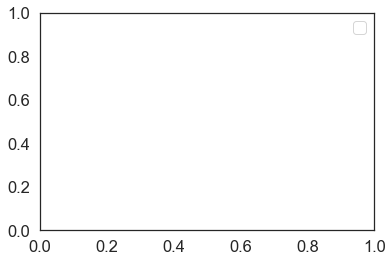

In [153]:
plt.legend()

In [144]:
cdf2
# counts_df[counts_df['SNR'] == 'MAX']
# sbjs = sorted([s for s in sbjs if s == 'SBJ' or 'SNR' in s])
# sbjs

,dist,K,count,perc,SNR,K-type,count_moved
0,chebychev,non geodesic,0,0.0,MAX,non-geodesic,0.0
1,chebychev,geodesic k=4,19,76.0,MAX,geodesic,19.0
2,chebychev,geodesic k=6,14,56.0,MAX,geodesic,14.0
3,chebychev,geodesic k=24,6,24.0,MAX,geodesic,6.0
4,chebychev,geodesic k=32,4,16.0,MAX,geodesic,4.0
5,chebychev,geodesic k=96,4,16.0,MAX,geodesic,4.0


['SBJ',
 'SBJ-A007',
 'SBJ-A014',
 'SBJ-A020',
 'SBJ-A027',
 'SBJ-A033',
 'SBJ-A050',
 'SBJ-A066',
 'SBJ-A083',
 'SBJ-A099',
 'SBJ-A132',
 'SBJ-SNR00.5',
 'SBJ-SNR00.6',
 'SBJ-SNR00.8',
 'SBJ-SNR01.0',
 'SBJ-SNR01.3',
 'SBJ-SNR02.0',
 'SBJ-SNR02.5',
 'SBJ-SNR03.3',
 'SBJ-SNR05.0',
 'SBJ-SNR10.0']

In [125]:
print(datadir)

/Users/dh/workspace/BDL/demapper/results/w3c_wnoise2/analysis/mappers_w3cv5lens2_fast.json/


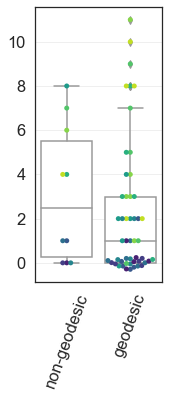

In [13]:
df_geo

,Mapper,SBJ,dist,K,R,G,CircleLoss,TransitionBetweeness,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
2625,DistsGeoBDLMapper_chebychev_24_10_50,SBJ,chebychev,24,10,50,0.051515,34.0,1.000000,1.000000,0.612245,9.0,3.08511,0.516763,26.6041,3.34709
2626,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A007,chebychev,24,10,50,1.608333,34.0,0.991150,0.999400,0.707965,11.0,3.15003,0.387105,31.8338,3.19281
2627,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A014,chebychev,24,10,50,0.014514,34.0,0.991803,0.999400,0.663934,12.0,3.23376,0.267006,33.6029,3.07592
2628,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A020,chebychev,24,10,50,0.982143,34.0,0.982759,0.998800,0.689655,11.0,3.13496,0.245131,34.6851,3.32338
2629,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A027,chebychev,24,10,50,0.604701,34.0,0.950617,0.997001,0.703704,9.0,2.89946,0.564607,31.4685,2.11304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR02.0,euclidean,96,50,90,0.046981,34.0,1.000000,1.000000,0.883903,8.0,2.38431,0.551528,14470.3000,6.97883
15746,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR02.5,euclidean,96,50,90,0.303710,34.0,1.000000,1.000000,0.884820,9.0,2.81370,0.332578,10110.9000,8.05170
15747,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR03.3,euclidean,96,50,90,0.097748,34.0,1.000000,1.000000,0.912555,8.0,2.52483,0.406887,14169.5000,8.04920
15748,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR05.0,euclidean,96,50,90,0.038292,2.0,1.000000,1.000000,0.877280,9.0,2.69297,0.309562,10521.4000,7.01438


In [11]:
df_nongeo

0       False
1       False
2       False
3       False
4       False
        ...  
2620     True
2621     True
2622     True
2623     True
2624     True
Name: dist, Length: 2625, dtype: bool

In [10]:
df_geo

,Mapper,SBJ,dist,K,R,G,CircleLoss,TransitionBetweeness,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
2625,DistsGeoBDLMapper_chebychev_24_10_50,SBJ,chebychev,24,10,50,0.051515,34.0,1.000000,1.000000,0.612245,9.0,3.08511,0.516763,26.6041,3.34709
2626,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A007,chebychev,24,10,50,1.608333,34.0,0.991150,0.999400,0.707965,11.0,3.15003,0.387105,31.8338,3.19281
2627,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A014,chebychev,24,10,50,0.014514,34.0,0.991803,0.999400,0.663934,12.0,3.23376,0.267006,33.6029,3.07592
2628,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A020,chebychev,24,10,50,0.982143,34.0,0.982759,0.998800,0.689655,11.0,3.13496,0.245131,34.6851,3.32338
2629,DistsGeoBDLMapper_chebychev_24_10_50,SBJ-A027,chebychev,24,10,50,0.604701,34.0,0.950617,0.997001,0.703704,9.0,2.89946,0.564607,31.4685,2.11304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR02.0,euclidean,96,50,90,0.046981,34.0,1.000000,1.000000,0.883903,8.0,2.38431,0.551528,14470.3000,6.97883
15746,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR02.5,euclidean,96,50,90,0.303710,34.0,1.000000,1.000000,0.884820,9.0,2.81370,0.332578,10110.9000,8.05170
15747,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR03.3,euclidean,96,50,90,0.097748,34.0,1.000000,1.000000,0.912555,8.0,2.52483,0.406887,14169.5000,8.04920
15748,DistsGeoBDLMapper_euclidean_96_50_90,SBJ-SNR05.0,euclidean,96,50,90,0.038292,2.0,1.000000,1.000000,0.877280,9.0,2.69297,0.309562,10521.4000,7.01438


### Plot of added noise with non-geodesic doing better

In [55]:

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'wnoise_w3cv5lens2_fast'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')


# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

table = []
sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
    noise_added = int(sbj.replace('SBJ', '')) - 100

    df_geodists = filter_dataframe(df_geo, sbj_filters)
    df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()

    # counts = {d:{} for d in dists}
#     for dist in dists:
    # !!!!! Limit to only the 4 distances that are relevant
    for dist in ['cosine', 'euclidean']:

        fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits_nongeo)
        table.append({
            'dist': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'noise': noise_added
        })
        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'dist': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'noise': noise_added
            })

counts_df = pd.DataFrame(data=table)


f, ax = plt.subplots(figsize=(10, 5))
# ax.set(xscale="log")

g = sns.lineplot(data=counts_df, x="noise", y="perc", hue="K", style="K", markers=True, dashes=False)
# g.set(xscale="log")
g.set_xlabel("Added noise")
g.set_ylabel("Percentage valid")
# g.set_xticks(sorted(Kvals))
# g.set_xticklabels(sorted(Kvals))
g.set(ylim=(0, 100))
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'noise_dists_distrib.png')
plt.savefig(save_path, dpi=150)
plt.close()


len(stats):  4500
len(results):  4500
len(stats):  4500
len(results):  4500


### Plot of removing data and correlation does as again

In [19]:

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'ss_w3cv6lens2_fast'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')


# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
# filter_by = FILTERS[PICKED_DATASET][1]
# df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
# target_metrics_limits_nongeo = {
#     'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
#     'coverage_nodes': [0.7, 1.0],
#     'distances_entropy': [2.0, 10000.0],
#     'hrfdur_stat': [0.15, 1.0],
# }

table = []
# sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
sbjs = ['SBJ99', 'SBJ99-50.0', 'SBJ99-75.0', 'SBJ99-83.0']
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
    if sbj == 'SBJ99':
        perc_rm = 100.0
    else:
        perc_rm = float(sbj.replace('SBJ99', '')) * (-1)

    df_geodists = filter_dataframe(df_geo, sbj_filters)
#     df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()

    # counts = {d:{} for d in dists}
    for dist in dists:
#         fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
#         cnt = count_passing(fdf, target_metrics_limits_nongeo)
#         table.append({
#             'dist': Distance type,
#             'K': 'non geodesic',
#             'count': cnt,
#             'perc': cnt / len(fdf) * 100.0,
#             'Percentage of Data kept': perc_rm
#         })
        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'Distance type': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'Percentage of Data kept': perc_rm
            })

counts_df = pd.DataFrame(data=table)

f, ax = plt.subplots(figsize=(10, 5))
# ax.set(xscale="log")

g = sns.lineplot(data=counts_df, x="Percentage of Data kept", y="perc", hue="Distance type", style="Distance type", markers=True, dashes=False)
# g.set(xscale="log")
g.set_ylabel("Percentage valid")
g.set(ylim=(0, 100))
g.invert_xaxis()
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'datarm_dists_distrib.png')
plt.savefig(save_path, dpi=150)
plt.close()



len(stats):  5000
len(results):  5000


### Plot of embeds

In [27]:
PICKED_DATASET = 'ss_w3cv8embed_fast'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')



max_val_tr_btweenness = 0
dfs = {}
limits = {}
for filter_by in FILTERS[PICKED_DATASET]:
    if filter_by in ['tSNEBDLMapperWtd']:
        continue
    print(filter_by)
    df_fb, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
    if max_val_tr_btweenness < max_values['TransitionBetweeness']:
        max_val_tr_btweenness = max_values['TransitionBetweeness']
    limits[filter_by] = max_values['TransitionBetweeness']# target_metrics_limits(max_values)
    if 'tSNE' in filter_by:
        df_fb['embed'] = 'tSNE'
        df_fb['perplexity'] = df_fb.apply(lambda x: str(x['perplexity']), axis=1)
    else:
        df_fb['perplexity'] = ''
    if 'Dist' in filter_by or 'Prep' in filter_by:
        df_fb['K'] = 'non geo'
        df_fb['prelens'] = 'Dist' if 'Dist' in filter_by else 'Prep'
    else:
        df_fb['K'] = df_fb.apply(lambda x: 'geo k={}'.format(x['K']), axis=1)
        df_fb['prelens'] = 'Wtd'
    df_fb['mapper_name'] = filter_by
    dfs[filter_by] = df_fb
    
for k in dfs.keys():
    df_fb = dfs[k]
    df_fb.loc[df_fb['TransitionBetweeness'] > (limits[k] * 0.99), 'TransitionBetweeness'] = max_val_tr_btweenness
    dfs[k] = df_fb
    
df = pd.concat(dfs.values())
df['TransitionBetweenessRev'] = df.apply(lambda x: 1.0 / (x['TransitionBetweeness'] + 1), axis=1)

target_metrics = ['TransitionBetweenessRev', 'coverage_nodes', 'hrfdur_stat', 'distances_entropy']

target_metrics_limits = {
    'TransitionBetweeness': [0, max_val_tr_btweenness * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}


EmbedBDLMapperWtd
len(stats):  345
len(results):  345
EmbedBDLMapperDist
len(stats):  345
len(results):  345
tSNEBDLMapperDist
len(stats):  345
len(results):  345
EmbedBDLMapperPrep
len(stats):  345
len(results):  345
tSNEBDLMapperPrep
len(stats):  345
len(results):  345


In [28]:
plot_results(df, 'SBJ99', [], ['embed', 'perplexity', 'prelens'], ['R', 'K'], 'G', 
             target_metrics=target_metrics, log_metrics=[], resdir=datadir,)

In [7]:
df = pd.concat(dfs.values())
df['TransitionBetweeness'].to_numpy()
sum(df['TransitionBetweeness'] == max_val_tr_btweenness)

43

In [20]:
df

,Mapper,SBJ,K,embed,edim,R,G,CircleLoss,TransitionBetweeness,coverage_nodes,...,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy,perplexity,mapper_name,embed_perplexity,R_K
75,EmbedBDLMapperWtd_12_CMDS_2_10_50,SBJ99,geo k=12,CMDS,2,10,50,0.142857,1.0,1.000000,...,0.440860,13.0,3.67509,0.361202,16.6329,3.55274,,EmbedBDLMapperWtd,CMDS_,10_geo k=12
76,EmbedBDLMapperWtd_12_CMDS_2_10_60,SBJ99,geo k=12,CMDS,2,10,60,0.222222,0.0,1.000000,...,0.495146,8.0,2.88861,0.375209,43.8614,4.54234,,EmbedBDLMapperWtd,CMDS_,10_geo k=12
77,EmbedBDLMapperWtd_12_CMDS_2_10_70,SBJ99,geo k=12,CMDS,2,10,70,0.266667,0.0,1.000000,...,0.643564,6.0,2.46554,0.388883,95.4481,4.60746,,EmbedBDLMapperWtd,CMDS_,10_geo k=12
78,EmbedBDLMapperWtd_12_CMDS_2_10_80,SBJ99,geo k=12,CMDS,2,10,80,0.337500,0.0,1.000000,...,0.718182,5.0,2.12590,0.195895,227.5210,4.54711,,EmbedBDLMapperWtd,CMDS_,10_geo k=12
79,EmbedBDLMapperWtd_12_CMDS_2_10_90,SBJ99,geo k=12,CMDS,2,10,90,0.179310,18.0,1.000000,...,0.832117,4.0,1.46758,0.258538,939.4780,5.31042,,EmbedBDLMapperWtd,CMDS_,10_geo k=12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,tSNEBDLMapperPrep_5_2_30_50,SBJ99,non geo,tSNE,2,30,50,14.500000,18.0,0.338050,...,0.287736,33.0,4.57376,0.315823,19.9934,4.83798,5,tSNEBDLMapperPrep,tSNE_5,30_non geo
251,tSNEBDLMapperPrep_5_2_30_60,SBJ99,non geo,tSNE,2,30,60,14.500000,18.0,0.549598,...,0.375335,34.0,4.62539,0.258913,66.1242,6.91278,5,tSNEBDLMapperPrep,tSNE_5,30_non geo
252,tSNEBDLMapperPrep_5_2_30_70,SBJ99,non geo,tSNE,2,30,70,14.500000,18.0,0.396491,...,0.569591,11.0,3.00331,0.249372,270.2830,8.17301,5,tSNEBDLMapperPrep,tSNE_5,30_non geo
253,tSNEBDLMapperPrep_5_2_30_80,SBJ99,non geo,tSNE,2,30,80,14.500000,18.0,0.367179,...,0.752821,8.0,2.33809,0.326500,1145.5300,8.30291,5,tSNEBDLMapperPrep,tSNE_5,30_non geo


In [10]:
sum(df2['TransitionBetweeness'] == max_val_tr_btweenness)

155

In [11]:
df2['TransitionBetweeness'].to_numpy()


array([ 1.,  0.,  0.,  0., 18.,  1., 18.,  0.,  0.,  0., 18.,  0.,  0.,
        0.,  0.,  2.,  2.,  2.,  1., 18.,  6.,  4.,  2.,  1.,  0., 18.,
       18.,  3.,  3.,  1.,  1.,  0.,  1.,  0., 18., 18.,  1.,  0.,  0.,
        0., 18.,  5.,  1.,  0.,  1.,  3.,  1.,  0.,  0., 18.,  3.,  2.,
        1.,  1.,  0.,  7.,  3.,  2.,  2.,  0., 18., 18., 18.,  2., 18.,
       18., 18., 18., 18.,  2., 18., 18., 18., 18.,  2.,  0.,  0.,  0.,
        1., 18.,  1.,  2.,  1.,  0.,  0., 18.,  3.,  1.,  1.,  1.,  5.,
        4.,  3.,  2., 18., 18., 18.,  8.,  3.,  2., 18., 18., 18.,  8.,
        3., 18.,  0.,  1., 18., 18., 18., 18.,  0.,  0., 18., 18., 18.,
       18.,  0.,  1., 18., 18.,  2., 18., 18., 18., 18., 18.,  3., 18.,
       18., 18., 18., 18.,  2., 18., 18., 18., 18., 18., 18., 18., 18.,
       18., 18., 18., 18., 18., 18.,  2., 18., 18., 18., 18., 18., 18.,
       18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
       18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18

In [12]:
df['TransitionBetweeness'].to_numpy()

array([ 1.,  0.,  0.,  0., 16.,  1., 16.,  0.,  0.,  0., 16.,  0.,  0.,
        0.,  0.,  2.,  2.,  2.,  1., 16.,  6.,  4.,  2.,  1.,  0., 16.,
       16.,  3.,  3.,  1.,  1.,  0.,  1.,  0., 16., 16.,  1.,  0.,  0.,
        0., 16.,  5.,  1.,  0.,  1.,  3.,  1.,  0.,  0., 16.,  3.,  2.,
        1.,  1.,  0.,  7.,  3.,  2.,  2.,  0., 16., 16., 16.,  2., 16.,
       16., 16., 16., 16.,  2., 16., 16., 16., 16.,  2.,  0.,  0.,  0.,
        1., 16.,  1.,  2.,  1.,  0.,  0., 16.,  3.,  1.,  1.,  1.,  5.,
        4.,  3.,  2., 18., 18., 18.,  8.,  3.,  2., 18., 18., 18.,  8.,
        3., 18.,  0.,  1., 18., 18., 18., 18.,  0.,  0., 18., 18., 18.,
       18.,  0.,  1., 18., 18.,  2., 18., 18., 18., 18., 18.,  3., 18.,
       18., 18., 18., 18.,  2.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  2.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6., 18

### Plot grid of mappers for Resolution and Gain for NeuMapper

In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

main_path = '/Users/dh/workspace/BDL/demapper/results/w3c_ss/v4-SBJ99'
sbj = 'v4-SBJ99'
mappers = sorted([[m] + [int(k) for k in m.split('_')[1:]] + [sbj]
                  for m in os.listdir(main_path)
                  if 'Mapper' in m])

df = pd.DataFrame(data=mappers, columns=['mapper', 'K', 'R', 'G', 'sbj'])



for K in [20, 30]:
    plot_grid(df, sbj, ['G'], ['R'], {'K': K}, '/Users/dh/workspace/BDL/demapper/results/w3c_ss',
              regen=True, plot_label='-G')


In [23]:
df

,mapper,K,R,G,sbj
0,EucNeuMapper_20_100_30,20,100,30,v4-SBJ99
1,EucNeuMapper_20_100_40,20,100,40,v4-SBJ99
2,EucNeuMapper_20_100_50,20,100,50,v4-SBJ99
3,EucNeuMapper_20_100_60,20,100,60,v4-SBJ99
4,EucNeuMapper_20_100_70,20,100,70,v4-SBJ99
5,EucNeuMapper_20_200_30,20,200,30,v4-SBJ99
6,EucNeuMapper_20_200_40,20,200,40,v4-SBJ99
7,EucNeuMapper_20_200_50,20,200,50,v4-SBJ99
8,EucNeuMapper_20_200_60,20,200,60,v4-SBJ99
9,EucNeuMapper_20_200_70,20,200,70,v4-SBJ99


### Other plots (deprecated)

In [ ]:


def create_plot(df, ax, hparam, target, title=None):
    labels = sorted(list(df[hparam].unique()))
    data = [df[df[hparam] == label][target] for label in labels]
    ax = sns.boxplot(data=data, ax=ax)
    ax = sns.swarmplot(data=data, color=".25", ax=ax, size=1.5)
    ax.set_xticklabels(labels, rotation=10)
    ax.set_xlabel(hparam)
    ax.set_ylabel(target)
    ax.set_title('Distribution of {} over {}'.format(target,hparam) if not title else title)
    ax.grid(alpha=0.4)
    return ax


In [ ]:

target = 'ChangePointsIndicesError'

plt.figure()
ax = create_plot(df, None, 'K', target)
plt.show()

plt.figure()
ax = create_plot(df, None, 'R', target)
plt.show()

plt.figure()
ax = create_plot(df, None, 'G', target)
plt.show()

In [ ]:

target = 'ChangePointsResiduals'
plt.figure()
ax = create_plot(df, None, 'K', target)
plt.show()

plt.figure()
ax = create_plot(df, None, 'R', target)
plt.show()

plt.figure()
ax = create_plot(df, None, 'G', target)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['R'], df['G'], df['K'], cmap=plt.cm.jet, linewidth=0.01)
plt.show()

# Plot of indices error

In [ ]:
df

In [ ]:
sorted(df[df['R'] == 300]['hrfdur_stat-mean'].tolist())